<a href="https://colab.research.google.com/github/trannguyen1510/Banana_Detection/blob/main/Notebooks/BannanaDetectionTrainedModel_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Connect to drive

In [2]:
# Tab này chỉ host chạy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 19.0MB/s 


In [4]:
# !pip install keras==2.1.5

In [5]:
# !pip install keras==2.1.5

In [6]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, opt-einsum, protobuf, wrapt, tensorboard, numpy, keras-preprocessing, six, typing-extensions, wheel, termcolor, flatbuffers, tensorflow-estimator, grpcio, google-pasta, gast, astunparse, h5py
Required-by: fancyimpute


In [7]:
tf.__version__

'2.4.0'

In [8]:
import keras as kr
kr.__version__

'2.4.3'

## Import dependencies

In [9]:
import cv2
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import os
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import skimage.draw

## Download Mask RCNN library

In [10]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 125.26 MiB | 40.35 MiB/s, done.
Resolving deltas: 100% (574/574), done.


In [11]:
os.chdir('/content/Mask_RCNN')

In [12]:
ROOT_DIR = '/content/project'

## Import MaskRCNN dependencies

In [13]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [14]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/project/Mask_RCNN',
 '/content']

In [15]:
train_image_path = os.path.join('/content/drive/My Drive/', 'train_trial')
test_image_path = os.path.join('/content/drive/My Drive/', 'test_trial')

## Create Configuration class for Detector

In [16]:
class DetectorConfig(Config):    
    NAME = 'banana'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 fruit class
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 25
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Extend existing Dataset class to customize methods

In [17]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """
    
    def load_labels(self, labels_list):
        for i, label in enumerate(labels_list):
            self.add_class('fruits', i + 1, label)
            
    def load_dataset(self, images_obj):
        for image_obj in images_obj:
            image_id = image_obj['image_id']
            image_path = image_obj['image_path']
            num_ids = image_obj['num_ids']
            polygons = image_obj['polygons']
            width = image_obj['width']
            height = image_obj['height']
            self.add_image("fruits", image_id=image_id, path=image_path,
                           width=width, height=height, polygons=polygons,num_ids=num_ids)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
      

In [18]:
!pip install xmltodict

In [19]:
labels = ["banana"]

In [20]:
def parse_single_annotation(label_obj):
    #print(label_obj)
    name = label_obj['name']
    # Get label
    num_id = labels.index(name) + 1
    bb_box = label_obj['bndbox']
    # Extract the xmin xmax ymin and ymax of bounding box
    xmin = int(bb_box['xmin'])
    xmax = int(bb_box['xmax'])
    ymin = int(bb_box['ymin'])
    ymax = int(bb_box['ymax'])
    # Convert it into polygon format. So we need 5 points for both x and y
    all_points_x = [xmin, xmax, xmax, xmin, xmin]
    all_points_y = [ymin, ymin, ymax, ymax, ymin]
    return all_points_x, all_points_y, num_id

## Parse the images and annotations and it in a single array

In [21]:
import xmltodict
import json
train_images = []
def transform_annotations(image_path):
    # Start the index from 100
    curr_idx = 100
    images_list = []
    c=0
    # List the files in the training or test path
    for i in os.listdir(os.path.join(image_path)):
        
        # Get the image path
        img_path = os.path.join(image_path, i)
        split_img_path = i.split('.')
        # check if the file is a .jpg ext. We ignore .xml file as they will be parsed based on .jpg file name
        if split_img_path[1] in ['jpg','JPG']:
            # Define dict key value pair required in coco dataset
            polygons = []
            num_ids = []
            # Read the image file 
            # file_data = cv2.imread(img_path)
            # Get the heigh and width. OpenCV shape is in the format h, w, depth
            height, width = 0,0
            # Open the xml file which has the same name of the image we have opened for this iteration
            with open(os.path.join(image_path, split_img_path[0] + '.xml')) as fd:
                # Load the xml -> convert xml to dict -> convert to json
                bb_file = json.loads(json.dumps(xmltodict.parse(fd.read())))
                # Get the heigh and width. OpenCV shape is in the format h, w, depth
                height, width = int(bb_file['annotation']['size']['height']),int(bb_file['annotation']['size']['width'])
                # There are two case - bb_file['annotation']['object'] can exist as a single dict or as a list of dict.
                # Thus, we need to do a check to see whether it is a list or not.
                # If the value is a data type of list:
                if isinstance(bb_file['annotation']['object'], list):
                    # Loop through each dict in the list
                    for obj in bb_file['annotation']['object']:
                        # Parse each annotation individually
                        all_points_x, all_points_y, num_id = parse_single_annotation(obj)
                        # Append the points into polygon list
                        polygons.append({
                            'all_points_x': all_points_x,
                            'all_points_y': all_points_y
                        })
                        # Append the id into the num_ids list
                        num_ids.append(num_id)
                # If the ['object'] key only contains a dict value
                else:
                    # We just need to parse a single annotation
                    all_points_x, all_points_y, num_id = parse_single_annotation(bb_file['annotation']['object'])
                    # Append it into polygon and num_ids list
                    polygons.append({
                        'all_points_x': all_points_x,
                        'all_points_y': all_points_y
                    })
                    num_ids.append(num_id)
            # For this image, we need to create a dict to represent it and all the corresponding annotations represented by polygons and num_ids key list
            image_label = {
                'image_path': img_path,
                'image_id': curr_idx,
                'polygons': polygons,
                'num_ids': num_ids,
                'height': height,
                'width': width
            }
            curr_idx = curr_idx + 1
            # Append it into the images_list
            images_list.append(image_label)
            c+=1
    print(c)
    return images_list

# Store annotations into the respective train and test datase

## Load the training dataset and prepare

In [22]:
train_images = transform_annotations(train_image_path)
print(train_images[0:5])
dataset_train = DetectorDataset()
dataset_train.load_labels(labels)
dataset_train.load_dataset(train_images)
dataset_train.prepare()

213
[{'image_path': '/content/drive/My Drive/train_trial/IMG_20201201_171657.jpg', 'image_id': 100, 'polygons': [{'all_points_x': [1311, 1783, 1783, 1311, 1311], 'all_points_y': [1272, 1272, 2012, 2012, 1272]}, {'all_points_x': [1673, 2495, 2495, 1673, 1673], 'all_points_y': [1209, 1209, 1734, 1734, 1209]}, {'all_points_x': [2045, 2833, 2833, 2045, 2045], 'all_points_y': [1284, 1284, 2022, 2022, 1284]}, {'all_points_x': [2820, 3464, 3464, 2820, 2820], 'all_points_y': [1187, 1187, 2194, 2194, 1187]}, {'all_points_x': [3245, 3873, 3873, 3245, 3245], 'all_points_y': [1247, 1247, 2022, 2022, 1247]}, {'all_points_x': [1014, 1680, 1680, 1014, 1014], 'all_points_y': [1006, 1006, 1672, 1672, 1006]}, {'all_points_x': [398, 1445, 1445, 398, 398], 'all_points_y': [1341, 1341, 2184, 2184, 1341]}], 'num_ids': [1, 1, 1, 1, 1, 1, 1], 'height': 3000, 'width': 4000}, {'image_path': '/content/drive/My Drive/train_trial/IMG_0895.JPG', 'image_id': 101, 'polygons': [{'all_points_x': [625, 2694, 2694, 625, 

## Load the test dataset and prepare

In [23]:
test_images = transform_annotations(os.path.join(test_image_path))
dataset_val = DetectorDataset()
dataset_val.load_labels(labels)
dataset_val.load_dataset(test_images)
dataset_val.prepare()

91


/content/drive/My Drive/train_trial/IMG_20201201_171657.jpg
3000 4000 3000 4000


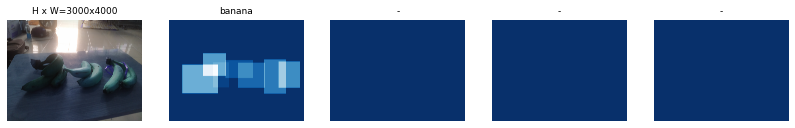

/content/drive/My Drive/train_trial/IMG_0895.JPG
2448 3264 2448 3264


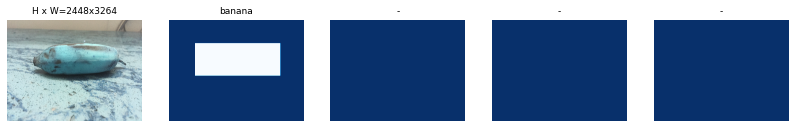

/content/drive/My Drive/train_trial/IMG_0894.JPG
2448 3264 2448 3264


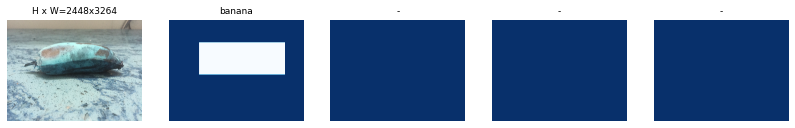

/content/drive/My Drive/train_trial/IMG_0940.JPG
2448 3264 2448 3264


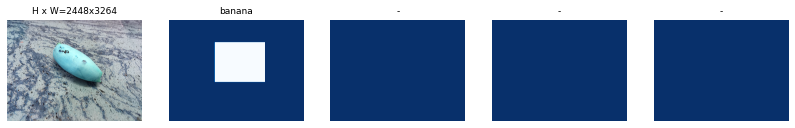

/content/drive/My Drive/train_trial/IMG_0939.JPG
2448 3264 2448 3264


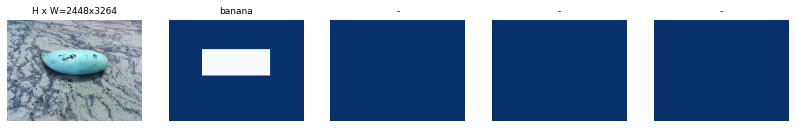

In [24]:
for i in range(5):
    image_id = train_images[i]['image_id']
    print(train_images[i]['image_path'])
    mask, num_id = dataset_train.load_mask(i)
    img_data = cv2.imread(train_images[i]['image_path'])
    h, w, _ = img_data.shape
    true_h,true_w = train_images[i]['height'],train_images[i]['width']
    print(h,w,true_h,true_w)
    if (h, w) != (true_h, true_w):
      print('need_rotate')
      img_data = cv2.rotate(img_data, cv2.ROTATE_90_COUNTERCLOCKWISE)
    num_id = [x - 1 for x in num_id]
    visualize.display_top_masks(img_data, mask, num_id, labels)

In [25]:
# # Check train folder if original image and its mask are match
# count1 = 0
# for i in range(len(train_images)):
#     # image_id = train_images[i]['image_id']
#     # print(train_images[i]['image_path'])
#     mask, num_id = dataset_train.load_mask(i)
#     img_data = cv2.imread(train_images[i]['image_path'])
#     h, w, _ = img_data.shape
#     true_h,true_w = train_images[i]['height'],train_images[i]['width']
#     # print(h,w,true_h,true_w)
#     if (h, w) != (true_h, true_w):
#       # print('need_rotate')
#       count1 += 1
#     # num_id = [x - 1 for x in num_id]
#     # visualize.display_top_masks(img_data, mask, num_id, labels)
# count1

In [26]:
## Check test folder if original image and its mask are match
# count2 = 0
# for i in range(len(test_images)):
#     # image_id = test_images[i]['image_id']
#     # print(test_images[i]['image_path'])
#     mask, num_id = dataset_val.load_mask(i)
#     img_data = cv2.imread(test_images[i]['image_path'])
#     h, w, _ = img_data.shape
#     true_h,true_w = test_images[i]['height'],test_images[i]['width']
#     # print(h,w,true_h,true_w)
#     if (h, w) != (true_h, true_w):
#       # print('need_rotate')
#       count2 += 1
#     # num_id = [x - 1 for x in num_id]
#     # visualize.display_top_masks(img_data, mask, num_id, labels)
# count2

In [27]:
new_model_path = '/content/drive/MyDrive/saved_model/banana/update_model.h5'

# Evaluate model

In [28]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims

## Create inference configuration

In [39]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
new_model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert new_model_path != "", "Provide path to trained weights"
print("Loading weights from ", new_model_path)
new_model.load_weights(new_model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/saved_model/banana/update_model.h5


In [43]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, augmentation=None)
        # print(image, image_meta, gt_class_id, gt_bbox, gt_mask)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        #print(r)
        # calculate statistics, including AP
        """compute_ap: Compute Average Precision at a set IoU threshold (default 0.5).

            Returns:
            mAP: Mean Average Precision
            precisions: List of precisions at different class score thresholds.
            recalls: List of recall values at different class score thresholds.
            overlaps: [pred_boxes, gt_boxes] IoU overlaps.
            """
        #print( r["class_ids"])
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

In [44]:
# evaluate model on train dataset
train_mAP = evaluate_model(dataset_train, new_model, inference_config)

In [45]:
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.831


In [46]:
# evaluate model on test dataset
test_mAP = evaluate_model(dataset_val,  new_model, inference_config)

In [48]:
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.716


# Predict output

In [49]:
# set color for class
def get_colors_for_class_ids(class_ids):
    class_ids = [x - 1 for x in class_ids]
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

5
42
46


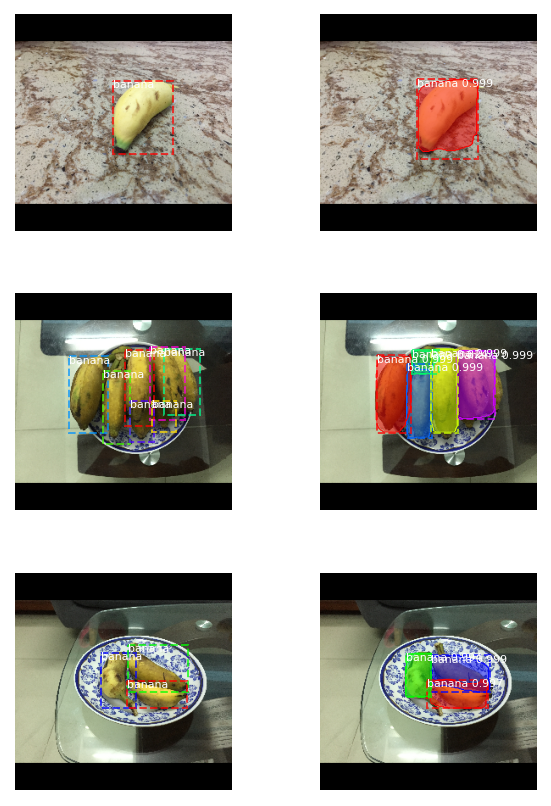

In [51]:
import cv2
import matplotlib.patches as patches

# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
start_idx = 0
for i in range(start_idx, start_idx + 3):
    
    image_id = random.choice(dataset.image_ids)
    print(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, augmentation=None)
    # print(len(original_image))
    # print(len(original_image[0]))

    # print(len(gt_mask))
    # print(len(gt_mask[0]))
    gt_mask1 = np.zeros((original_image.shape[0],original_image.shape[1],gt_bbox.shape[0]))
    plt.subplot(6, 2, 2*(i-start_idx) + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask1, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    plt.subplot(6, 2, 2*(i-start_idx) + 2)
    results = new_model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

## Detect an image

In [52]:
def load_image(path):
  image = skimage.io.imread(path)
  # If grayscale. Convert to RGB for consistency.
  if image.ndim != 3:
      image = skimage.color.gray2rgb(image)
  # If has an alpha channel, remove it for consistency
  if image.shape[-1] == 4:
      image = image[..., :3]
  original_shape = image.shape
  image, window, scale, padding, crop = utils.resize_image(
      image,
      min_dim=config.IMAGE_MIN_DIM,
      min_scale=config.IMAGE_MIN_SCALE,
      max_dim=config.IMAGE_MAX_DIM,
      mode=config.IMAGE_RESIZE_MODE)
  return image


def display_image(image, figsize=(16, 16), ax=None):
    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')

    masked_image = image.astype(np.uint32).copy()
    ax.imshow(masked_image.astype(np.uint8))
    # plt.show()

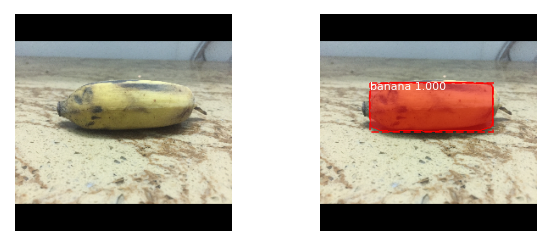

In [53]:
# Drag and drop image to detect to google colab

fig = plt.figure(figsize=(10, 30))

path_to_detect = '/content/IMG_0895.JPG'

new_image = load_image(path_to_detect)
plt.subplot(6, 2, 1)
display_image(new_image, ax=fig.axes[-1])

results = new_model.detect([new_image]) #, verbose=1)
r = results[0]

plt.subplot(6, 2, 2)
visualize.display_instances(new_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], 
                            colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])